#   Intro

This notebook is built to use GPU in order to apply the stance classification on larger scales datasets.

# Part 1: Create Embedding Dataset

A flow that connects to Google Drive in order to run the embedder and dataset class with GPU on larger scales of data.

Output is a merged .pkl file saved in your mounted Drive for the Embedding Dataset Object.

Be sure to upload the trained embedding resources to this local env before running the flow:

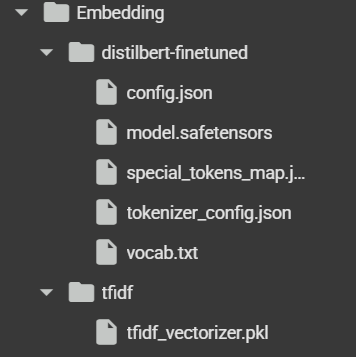

NOTE: The code in this notebook is an adapted replica of the code from the main project files:
- dataset.py
- embedder.py
- classifiers.py

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 12.5 MB/s eta 0:00:00


In [ ]:
import os

# Data & Embeddings
# Get the project root directory (move up one level from the 'Config' folder)
project_root = "/content"

# Base directories (relative to project root)
EMBEDDING_DIR_PATH = os.path.join(project_root, "Embedding")
EMBEDDING_PATH = os.path.join(EMBEDDING_DIR_PATH, "distilbert-finetuned")  # Full path to the embedding directory
TFIDF_PATH = os.path.join(EMBEDDING_DIR_PATH, "tfidf", "tfidf_vectorizer.pkl")  # Full path to the TF-IDF vectorizer

In [ ]:
# embedder.py

import numpy as np
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import joblib
import warnings
from sklearn.exceptions import InconsistentVersionWarning

warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt', quiet=True)

class Embedder:
    def __init__(self):
        """
        Initializes the Embedder object with a DistilBERT model and a TF-IDF vectorizer.,
        both loaded from pretrained files.
        """
        # Set device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load the DistilBERT tokenizer and model
        self.tokenizer = DistilBertTokenizer.from_pretrained(EMBEDDING_PATH)
        self.distilbert_model = DistilBertModel.from_pretrained(EMBEDDING_PATH).to(self.device)

        # Load the TF-IDF vectorizer
        self.tfidf_vectorizer = joblib.load(TFIDF_PATH)


    def embed(self, input_text, method="distilbert"):
        """
        Generate embeddings for the input text using the specified method.
        Generate embeddings by sentence chunking + mean pooling per sentence.
        Longer comments benefit from dividing into smaller semantic units.

        Parameters:
        - input_text (str): The text to be embedded.
        - method (str): The embedding method ("distilbert" or "tf-idf").

        Returns:
        - embedding (np.ndarray): The embedding for the full input text.
        """
        sentences = sent_tokenize(input_text)
        sentence_embeddings = []

        for sent in sentences:
            if method == "distilbert":
                sent_emb = self._distilbert_embedding(sent)
            elif method == "tf-idf":
                sent_emb = self._tfidf_embedding(sent)
            else:
                raise ValueError("Unsupported embedding method. Use 'distilbert' or 'tf-idf'.")
            sentence_embeddings.append(sent_emb)

        # Mean-pool sentence-level embeddings
        if len(sentence_embeddings) == 0:
            return np.zeros_like(self._distilbert_embedding(""))  # fallback for empty input

        stacked = np.stack(sentence_embeddings)  # shape: (n_sentences, emb_dim)
        mean_embedding = stacked.mean(axis=0)
        return mean_embedding


    def _distilbert_embedding(self, input_text):
        """
        Generate embeddings using the DistilBERT model.

        Parameters:
        - input_text (str): The text to be embedded.

        Returns:
        - embedding (torch.Tensor): A mean pooling vector from the model over the entire input -> Embedding for the input text (comment).
        """
        # Tokenize and encode the input text
        inputs = self.tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: val.to(self.device) for key, val in inputs.items()}

        with torch.no_grad():
            # Pass the input through the DistilBERT model
            outputs = self.distilbert_model(**inputs)
            last_hidden = outputs.last_hidden_state # shape: (1, seq_len, hidden_size)
            attention_mask = inputs["attention_mask"]

            # Mean pooling over all non-padding tokens
            mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            sum_embeddings = torch.sum(last_hidden * mask_expanded, dim=1)
            sum_mask = mask_expanded.sum(dim=1)

            mean_pooled = sum_embeddings / sum_mask
            return mean_pooled.cpu().numpy().flatten()


    def _tfidf_embedding(self, input_text):
        """
        Generate embeddings using the TF-IDF model.

        Parameters:
        - input_text (str): The text to be embedded.

        Returns:
        - embedding (np.ndarray): The embedding for the input text.
        """
        # Transform the input text using the TF-IDF vectorizer
        embedding = self.tfidf_vectorizer.transform([input_text])
        return embedding.toarray().flatten()

In [ ]:
# dataset.py

from logging import exception
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import random
import re
import contractions
import torch
from torch.utils.data import Dataset, DataLoader

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
STOPWORDS = set(stopwords.words('english'))

LABELS_ENCODER = {
    "Pro-Palestine": 0,
    "Pro-Israel": 1,
    "Undefined": 2
}

# ----------------------------------------------------------------------
# 0.  Tiny CSV cache (load once, reuse for every split)
# ----------------------------------------------------------------------

class _CSVCache:
    '''
    Use to avoid re-loading a CSV file multiple times
    '''
    df = None                 # class attribute

def _load_csv(path, encoding='utf-8'):
    if _CSVCache.df is None:             # load once, reuse for all splits
        try:
            _CSVCache.df = pd.read_csv(path, encoding=encoding)
        except UnicodeDecodeError:
            _CSVCache.df = pd.read_csv(path, encoding='ISO‑8859‑1')
    return _CSVCache.df



# ----------------------------------------------------------------------
#  Text Augmentation methods, applied in TextDataset
# ----------------------------------------------------------------------

class TextAugmenter:
    def __init__(self, adversation_ratio=0.1, methods=None):
        self.adversation_ratio = adversation_ratio
        self.methods = methods or ['wordnet']

    def random_deletion(self, sentence):
        '''
        Randomally delete words from the sentence
        '''
        words = word_tokenize(sentence)
        return " ".join([word for word in words if random.random() > self.adversation_ratio])

    def random_swap(self, sentence):
        '''
        Randomally swap 2 words of the sentence
        '''
        words = word_tokenize(sentence)
        for _ in range(int(len(words) * self.adversation_ratio)):
            idx1, idx2 = random.sample(range(len(words)), 2)
            words[idx1], words[idx2] = words[idx2], words[idx1]
        return " ".join(words)

    def get_wordnet_synonyms(self, word, pos=None):
        '''
        Randomally replace a word with a synonim
        '''
        synonyms = set()
        for syn in wordnet.synsets(word, pos=pos):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name().replace('_', ' '))
        synonyms.discard(word)
        return list(synonyms)

    def get_wordnet_pos(self, treebank_tag):
        '''
        Use POS to choose the word to replace
        '''
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None

    def synonym_replacement(self, sentence):
        '''
        Randomally replace a word with a synonim
        '''
        words = word_tokenize(sentence)
        pos_tags = pos_tag(words)
        augmented_words = []
        for word, pos in pos_tags:
            if word.lower() in STOPWORDS:
                augmented_words.append(word)
                continue
            wordnet_pos = self.get_wordnet_pos(pos)
            if wordnet_pos and random.random() < self.adversation_ratio:
                synonyms = self.get_wordnet_synonyms(word, pos=wordnet_pos)
                if synonyms:
                    augmented_words.append(random.choice(synonyms))
                else:
                    augmented_words.append(word)
            else:
                augmented_words.append(word)
        return " ".join(augmented_words)

    def augment_comment(self, comment):
        method = random.choice(self.methods)
        if method == 'deletion':
            return self.random_deletion(comment)
        elif method == 'swap':
            return self.random_swap(comment)
        elif method == 'wordnet':
            return self.synonym_replacement(comment)
        else:
            return comment  # Fallback


# ----------------------------------------------------------------------

class TextDataset(Dataset):
    """
    Hold ALL rows (TRAIN / VAL / TEST) internally.
    Augmentation / undersampling are applied **only** to the TRAIN rows.
    Call get_subset('TRAIN'|'VAL'|'TEST') to obtain a view that behaves
    like a normal torch Dataset.
    """
    def __init__(self, csv_path, id_column_idx, comment_column_idx, label_column_idx, split_column_idx,
                 augmented_classes=[], augmentation_ratio=3, augmentation_methods = ['wordnet'], adversation_ratio=0.1, undersampling_targets={}):
        """
        Initiates the dataset, which is the base Dataset for the embeddings.

        Args:
            csv_path (str): The path to the .csv data file.
            id_column_idx (int): Idx for the ID column in the dataframe.
            comment_column_idx (int): Idx for the text column in the dataframe.
            label_column_idx (int): Idx for the label column in the dataframe.
            split_column_idx (int): Idx for the subset column in the dataframe, indicating how to split it.
            augmented_classes (list): A list of the classes to augment. Chose from ['Pro-Israel', 'Pro-Palestine', 'Undefined']
            augmentation_ratio (int): Increase in the comments number. Meaning -> 1 comments turns to 1 + AUGMENTATION_RATIO comments.
            augmentation_methods (list): Choose from ['deletion', 'swap', 'wordnet'].
            adversation_ratio (float): Replacement ratio within the comment.
            undersampling_targets (dict): A mapping object of how much to undersample each class.
        """
        self.csv_path = csv_path
        self.id_column_idx = id_column_idx
        self.comment_column_idx = comment_column_idx
        self.label_column_idx = label_column_idx
        self.split_column_idx = split_column_idx
        self.action = 'regular'

        # ------------ load --------------------------------------------------
        df = _load_csv(csv_path)

        # ------------ basic text cleaning ------------------------------------------
        df = self.__preprocess(df)

        # ------------ TRAIN‑only operations ----------------------------------------
        mask_train = df.iloc[:, split_column_idx] == "TRAIN"

        if undersampling_targets:
            df.loc[mask_train] = self._undersample(
                df.loc[mask_train], undersampling_targets)
            self.action = 'undersampled'

        if (augmented_classes and augmentation_ratio > 0
                and adversation_ratio > 0):
            df = self._augment(df, mask_train,
                             augmented_classes, augmentation_ratio,
                             augmentation_methods, adversation_ratio)
            self.action = 'augmented'

        df.reset_index(drop=True, inplace=True)  # keep indices clean

        # Encode labels if not yet encoded
        label_col = df.columns[self.label_column_idx]

        # Handle string labels: map to integers via LABELS_ENCODER
        if df[label_col].dtype == object:
            mapped = df[label_col].map(LABELS_ENCODER)
            unknowns = df[~df[label_col].isin(LABELS_ENCODER)]
            if not unknowns.empty:
                raise ValueError(f"[Label Error] Found unknown string labels: {unknowns[label_col].unique().tolist()}")
            df[label_col] = mapped
        # Handle numeric labels: check that they’re valid
        else:
            invalid_labels = df.loc[~df[label_col].isin(LABELS_ENCODER.values()), label_col].unique()
            if len(invalid_labels) > 0:
                raise ValueError(f"[Label Error] Found invalid numeric labels: {invalid_labels}")

        # Save df as class attr
        self.data = df

        # pre‑compute row indices per split for fast lookup
        self.idx_split = {
            s: np.flatnonzero(df.iloc[:, split_column_idx] == s)
            for s in ("TRAIN", "VAL", "TEST")
        }

        print(f"[TextDataset] rows: "
              f"train={len(self.idx_split['TRAIN'])}, "
              f"val={len(self.idx_split['VAL'])}, "
              f"test={len(self.idx_split['TEST'])}")

    # ------------------------------------------------------------------ helpers ---

    @staticmethod
    def _normalize(text: str) -> str:
        """
        Perform basic text normalization:
        - Replace quotes with a placeholder (to mark them)
        - Replace URLs with <URL>.
        - Replace user mentions with <USER>.
        - Clean hashtags, retaining the word only.
        - Remove irrelevant characters (e.g., special symbols, emojis).
        - Normalize whitespace.
        """
        replacements = {
            '“': '"', '”': '"', '‘': "'", '’': "'",
            'â\x80\x9c': '"', 'â\x80\x9d': '"', 'â\x80\x99': "'", '&#x200B;': ' ',
            '&amp;': '&', '&lt;': '<', '&gt;': '>'
        }

        for bad_char, good_char in replacements.items():
            text = text.replace(bad_char, good_char)

        text = re.sub(r'(^|\n)\s*(?:>|\&gt;).*?(?=\n|$)', '<QUOTE>', text) # Any line that starts with > or &gt; is a quoted parent text
        try:
          text = contractions.fix(text)  # Expand contractions
        except Exception:
          text = text
        text = " ".join(text.split())  # Normalize whitespace
        text = re.sub(r'http\S+|www\S+|https\S+', '<URL>', text, flags=re.MULTILINE)  # Replace URLs
        text = re.sub(r'@\w+', '<USER>', text)  # Replace user mentions
        text = re.sub(r'#(\w+)', r'\1', text)  # Clean hashtags, retain the word
        text = re.sub(r'[^\w\s.,!?\'"\{\(\[\-\\/:;]', '', text)  # Remove irrelevant characters
        return text

    def __preprocess(self, df):
        """
        Apply text preprocessing to the comment column with a progress bar.
        In addition, drop irrelevant comments and nans.
        """
        # Wrap the progress bar around the column iteration
        tqdm.pandas(desc="Cleaning Comments")
        df.iloc[:, self.comment_column_idx] = df.iloc[:, self.comment_column_idx].progress_apply(self._normalize)
        df = df.dropna(subset=[df.columns[self.comment_column_idx]])
        df = df[
        df[df.columns[self.comment_column_idx]].apply(lambda x: len(x.split()) >= 2)
        ]
        return df

    def _undersample(self, df, targets: dict):
        """
        Performs undersampling so that all the labels will have a predefined number of rows in df (later to be self.data).
        Args:
            df (pd.DataFrame): The df for processing.
            targets (Dict(str:int)): A dictionary that defined the max number of rows for each label in the output like:
                {
                    "Pro-Palestine": 5500,
                    "Pro-Israel": 5500,
                    "Undefined": 5500
                }
        """
        dfs = []
        for lab, n in targets.items():
            lab_df = df[df.iloc[:, self.label_column_idx] == lab]
            dfs.append(lab_df.sample(min(n, len(lab_df)), random_state=42))
        return pd.concat(dfs, ignore_index=True)

    def _augment(self, df, mask_train, classes, ratio, methods, adv_ratio):
        """
        Performs augmentation using the TextAugmenter class to the classes that needs augmentation.
        Augmentation will create |ratio| adversed copies of comments from the augmented class, giving them unique UIDs.
        Args:
            df (pd.DataFrame): The df for processing.
            mask_train (pd.DataFrame): boolean mask selecting TRAIN rows inside *df*.
            classes (List(str)): The classes to augment (class labels like "Pro-Israel").
            ratio (int): Number of new adversed copies to add.
            methods (List(str)): A list with the augmentation methods.
            adv_ratio (float): Ratio of each comment (words from total comment) to adverse.

        NOTE: All of the params are handled in the llm_config.py file.
        """
        aug = TextAugmenter(adv_ratio, methods)
        train_df = df.loc[mask_train]
        extra = []

        for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Augment", unit="row"):
            lab = row.iloc[self.label_column_idx]
            if lab not in classes:
                continue
            for i in range(int(ratio)):
                new = row.copy()
                new.iloc[self.comment_column_idx] = aug.augment_comment(row.iloc[self.comment_column_idx])
                new.iloc[self.id_column_idx]  = f"{row.iloc[self.id_column_idx]}_aug{i+1}"
                extra.append(new)
        if extra:
            df = pd.concat([df, pd.DataFrame(extra, columns=df.columns)], ignore_index=True)
        return df

    def save_to_csv(self, output_repo: str = "Data"):
        """
        Save the dataset to a CSV file for inspection.
        """
        action_tag = getattr(self, "action", "regular")     # augmented / undersampled / regular
        filename  = f"{action_tag}_research_data_for_inspection.csv"
        out_path = Path(output_repo) / filename
        self.data.to_csv(out_path, index=False)
        print(f"[TextDataset] saved CSV → {out_path}")

    # -------------------------- Dataset API -------------------
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return [self[i] for i in range(*idx.indices(len(self)))]

        row = self.data.iloc[idx]
        comment_id = row.iloc[self.id_column_idx]
        comment    = row.iloc[self.comment_column_idx]
        encoded_label = LABELS_ENCODER.get(row.iloc[self.label_column_idx])
        return comment_id, comment, encoded_label



class EmbeddingDataset(Dataset):
    '''
    Dataset class to handle embedding generation.
    For modularity, as this object is the needed object for classification task,
    it is responsible for the creation of the TextDatasets and their modification to Embedding
    based one.
    Caching of dataset memory is defined to avoid re-calculations of embeddings.
    The embeddings are precomputed on init to support non NN models that cannot handle
    a dataloader, so beware of memory usage.
    If a strict NN based model is selected as best model, there is no need for the pre-computation.

    NOTE: One dataset will be created from a .csv file and will have TRAIN, VAL and TEST callable subsets (using _View).
    '''
    class _View(Dataset):
        def __init__(self, emb, labels, idx):
            self.embeddings, self.labels = emb[idx], labels[idx]
        def __len__(self):        return len(self.labels)
        def __getitem__(self, i): return self.embeddings[i], self.labels[i]

    def __init__(self, text_dataset, embedder, embedding_method, cache_dir=r"Data\cache"):
        """
        Creates the Dataset instance which fits the classification task.
        Most recurrent parameters are used to initiate the TextDataset in the init.
        Args:
            text_dataset (TextDataset): A pre-computed TextDataset instance
            embedder (Embedder): Embedder instance for generating embeddings.
            embedding_method (str): Method for embedding generation (e.g., 'distilbert', 'tf-idf').
            cache_dir (str): Directory to save the pre-computed embeddings instead of re-calculate.
        """
        # ---- load CSV once -------------------------------------------------
        self.text_dataset = text_dataset
        self.embedder, self.embedding_method = embedder, embedding_method
        cache_dir = Path(cache_dir); cache_dir.mkdir(exist_ok=True)
        self.action = self.text_dataset.action
        self.cache_file = cache_dir / f"{embedding_method}_embeddings_{self.action}.pkl"

        if self.cache_file.exists():
            print(f"[EmbeddingDataset]: Loading precomputed embeddings from {self.cache_file}...")
            with open(self.cache_file, "rb") as f:
                blob = pickle.load(f)
            self.embeddings = blob["embeddings"]          # (N,D) torch tensor
            self.labels = blob["labels"]           # (N,)  torch tensor
        else:
            print(f"[EmbeddingDataset]: Precomputing embeddings and saving to {self.cache_file}...")
            self.embeddings, self.labels = self._build_and_cache()
        print("[EmbeddingDataset Status]: Embedding generation complete.")


    def _build_and_cache(self):
        emb, lab = [], []
        for txt in tqdm(self.text_dataset.data.iloc[:, self.text_dataset.comment_column_idx],
                        total=len(self.text_dataset.data), desc="Embedding Comments"):
            v = self.embedder.embed(txt, method=self.embedding_method)
            emb.append(torch.as_tensor(v, dtype=torch.float32))
        emb = torch.stack(emb)
        lab = torch.tensor(
            self.text_dataset.data.iloc[:, self.text_dataset.label_column_idx].to_numpy(),
            dtype=torch.long)
        with open(self.cache_file, "wb") as f:
            pickle.dump({"embeddings": emb, "labels": lab}, f)
        return emb, lab
    # --------------------- Public Methods ---------------------------------
    def get_subset(self, split: str) -> Dataset:
        """
        Get a desired split from the Dataset -> TRAIN, VAL, TEST or any combination using '+'.

        Example:
            get_subset("TRAIN") → standard
            get_subset("TRAIN+VAL") → merged dataset
            get_subset("TRAIN+VAL+TEST") → full dataset
        """
        if "+" in split:
            splits = list(set(split.split("+")))
            all_idx = []
            for sub in splits:
                sub = sub.strip().upper()
                if sub not in self.text_dataset.idx_split:
                    raise ValueError(f"[Split Error] Unknown split name: {sub}")
                all_idx.append(self.text_dataset.idx_split[sub])
            idx = np.concatenate(all_idx)
        else:
            split = split.strip().upper()
            if split not in self.text_dataset.idx_split:
                raise ValueError(f"[Split Error] Unknown split name: {split}")
            idx = self.text_dataset.idx_split[split]

        return self._View(self.embeddings, self.labels, idx)

    # --------------------- Dataset API ---------------------------------
    def __len__(self):
        return len(self.text_dataset)  # Length is based on the original TextDataset

    def __getitem__(self, idx):
        """
        Return the precomputed embedding and label for the given index.
        """
        return self.embeddings[idx], self.labels[idx]

def _to_numpy(t):
    """
    Helper:  tensor  ➜  numpy (always on CPU, detached).
    Accepts torch.Tensor or anything that is already a numpy array.
    """
    if isinstance(t, torch.Tensor):
        return t.detach().cpu().numpy()
    return np.asarray(t)

def get_dataloader(dataset, batch_size=32, shuffle=True, num_workers=2):
    '''
    Will create the DataLoader object.
    Assumption is that a Dataset object is passed. Function will response if the dataset is TextDataset or EmbeddingDataset.
    If EmbeddingDataset, this function will return a Dataloader and a (X, y) tuple for other scikit models.
    Else, if dataset is TextDataset it will return a text dataset for it, which is designed for analysis of Transformer model's feed.
    The function is GPU‑safe:   `.cpu()` before `.numpy()`.

    Args:
        dataset (TextDataset or EmbeddingDataset): The original dataset object.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle the dataset.
        num_workers (int): Number of subprocesses for data loading.

    Returns:
        if type(dataset) == 'TextDataset':
            DataLoader: A PyTorch DataLoader object for text output.
        elif type(dataset) == 'EmbeddingDataset':
            1. DataLoader: A PyTorch DataLoader object for embedding output.
            2. tuple: An (X, y) tuple for other scikit models.
    '''
    print(f'[Dataloader Status]: Preparing the dataloader...')
    pin = torch.cuda.is_available()          # use pinned memory when GPU present
    dl = DataLoader(dataset,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    num_workers=num_workers,
                    pin_memory=pin)

    # --- TextDataset: nothing else to do ---------------------------------
    if 'TextDataset' in dataset.__class__.__name__:
        return dl

    # -------- EmbeddingDataset or its _View -------------------------------------
    if isinstance(dataset, EmbeddingDataset) or isinstance(dataset, EmbeddingDataset._View):
        # quick peek at first batch
        for b, (_, y_b) in enumerate(dl):
            print(f"[DL] peek batch {b}: y[:5] =", _to_numpy(y_b)[:5])
            break

        X = _to_numpy(dataset.embeddings)
        y = _to_numpy(dataset.labels)
        print(f"[DL] EmbeddingDataset ready. X shape {X.shape}, y len {len(y)}")
        return dl, (X, y)

    # -------- unknown dataset ---------------------------------------------------
    raise ValueError(f"[DL] Unrecognized dataset type: {type(dataset)}")

def patch_cached_labels(pkl_path):
    '''
    Had a reccurring problem with the datasets so added this utility to fix the label encodings
    of a cached dataset without having to re-calculate.

    Use like:
    patch_cached_labels("Data/cache/distilbert_embeddings_regular.pkl")
    '''
    with open(pkl_path, 'rb') as f:
        blob = pickle.load(f)

    labels = blob["labels"]
    if not torch.is_tensor(labels):
        labels = torch.tensor(labels, dtype=torch.long)

    # Fix labels that are outside expected range
    corrected_labels = []
    for lbl in labels:
        lbl_int = int(lbl)
        if lbl_int in LABELS_ENCODER.values():
            corrected_labels.append(lbl_int)
        else:
            print(f"[Warning] Skipping invalid label: {lbl_int}")
            corrected_labels.append(-1)  # or raise error if strict

    blob["labels"] = torch.tensor(corrected_labels, dtype=torch.long)

    with open(pkl_path, 'wb') as f:
        pickle.dump(blob, f)

    print(f"[Patch] Labels fixed and saved back to: {pkl_path}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Main

In [ ]:
import pandas as pd

DATA_PATH = "/content/drive/My Drive/reddit_opinion_PSE_ISR_cleaned_for_embedding.csv"
ID_COLUMN_IDX = 0
COMMENT_COLUMN_IDX = 1
LABEL_COLUMN_IDX = 2
SUBSET_COLUMN_IDX = 3

txt_regular = TextDataset(
    csv_path          = DATA_PATH,
    id_column_idx     = ID_COLUMN_IDX,
    comment_column_idx= COMMENT_COLUMN_IDX,
    label_column_idx  = LABEL_COLUMN_IDX,
    split_column_idx  = SUBSET_COLUMN_IDX,  # TRAIN / VAL / TEST column
    augmented_classes = [],                 # ‑‑ no aug
    augmentation_ratio= 0,
    undersampling_targets = {},             # ‑‑ no undersampling
)

Cleaning Comments: 100%|██████████| 2697930/2697930 [01:46<00:00, 25222.95it/s]


[TextDataset] rows: train=0, val=0, test=2683230


In [ ]:
EMB_METHODS = ["distilbert"]
embedder    = Embedder()                  # your wrapper around HF / TF‑IDF

# embedding_sets: dict[str, dict[str, EmbeddingDataset]] = {}   # {method : {variant : EmbeddingDataset}}

# for method in EMB_METHODS:
#     embedding_sets[method] = {
#         "regular"      : EmbeddingDataset(txt_regular,      embedder, method),
#     }

In [ ]:
import os
import pickle
from tqdm import tqdm
from google.colab import runtime

def embed_in_chunks_resumable(dataset, embedder, method: str,
                              chunk_size: int = 100_000,
                              output_dir: str = "/content/cache_embeddings",
                              drive_dir: str = "/content/drive/MyDrive/reddit_embeddings",
                              merge_after: bool = True,
                              disconnect: bool = False):

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(drive_dir, exist_ok=True)

    total_chunks = (len(dataset) + chunk_size - 1) // chunk_size

    for chunk_id in range(total_chunks):
        chunk_filename = f"{method}_chunk_{chunk_id:03d}.pkl"
        local_path = os.path.join(output_dir, chunk_filename)
        drive_path = os.path.join(drive_dir, chunk_filename)

        if os.path.exists(drive_path):  # <-- Only check drive_path now
            print(f"✓ Skipping existing chunk {chunk_id + 1}: {chunk_filename}")
            continue

        print(f"→ Embedding chunk {chunk_id + 1}/{total_chunks}")
        chunk = dataset[chunk_id * chunk_size: (chunk_id + 1) * chunk_size]
        ids, texts = zip(*[(ex[0], ex[1]) for ex in chunk])  # ex: (id, text, label)

        embeddings = []
        for txt in tqdm(texts, desc="Embedding texts", leave=False):
            emb = embedder.embed(txt, method)
            embeddings.append(emb)

        with open(local_path, "wb") as f:
            pickle.dump((ids, embeddings), f)

        os.system(f"cp '{local_path}' '{drive_path}'")
        print(f"✓ Saved {chunk_filename} to both local and Drive.")

    print("✅ All chunks processed.")

    if merge_after:
        print("🔄 Merging all chunks from Drive into a single file...")
        all_ids, all_embs = [], []

        # Scan Drive directory for all matching chunk files
        all_files = os.listdir(drive_dir)
        chunk_files = sorted([f for f in all_files if f.startswith(f"{method}_chunk_") and f.endswith(".pkl")])

        for filename in chunk_files:
            full_path = os.path.join(drive_dir, filename)
            try:
                with open(full_path, "rb") as f:
                    ids, embs = pickle.load(f)
                    all_ids.extend(ids)
                    all_embs.extend(embs)
            except Exception as e:
                print(f"⚠️ Failed to load {filename}: {e}")

        merged_path = os.path.join(drive_dir, f"{method}_FULL.pkl")
        with open(merged_path, "wb") as f:
            pickle.dump((all_ids, all_embs), f)

        print(f"✅ Merged embedding file saved to: {merged_path}")

    if disconnect:
        print("🚪 Disconnecting Colab runtime...")
        runtime.unassign()

In [ ]:
embed_in_chunks_resumable(
    dataset    = txt_regular,
    embedder   = embedder,
    method     = "distilbert",
    chunk_size = 200_000,  # or smaller/larger
    output_dir = "/content/cache_embeddings",
    drive_dir  = "/content/drive/MyDrive/reddit_embeddings"
)

✓ Skipping existing chunk 1: distilbert_chunk_000.pkl
✓ Skipping existing chunk 2: distilbert_chunk_001.pkl
✓ Skipping existing chunk 3: distilbert_chunk_002.pkl
✓ Skipping existing chunk 4: distilbert_chunk_003.pkl
✓ Skipping existing chunk 5: distilbert_chunk_004.pkl
✓ Skipping existing chunk 6: distilbert_chunk_005.pkl
✓ Skipping existing chunk 7: distilbert_chunk_006.pkl
✓ Skipping existing chunk 8: distilbert_chunk_007.pkl
✓ Skipping existing chunk 9: distilbert_chunk_008.pkl
✓ Skipping existing chunk 10: distilbert_chunk_009.pkl
✓ Skipping existing chunk 11: distilbert_chunk_010.pkl
✓ Skipping existing chunk 12: distilbert_chunk_011.pkl
✓ Skipping existing chunk 13: distilbert_chunk_012.pkl
✓ Skipping existing chunk 14: distilbert_chunk_013.pkl
✅ All chunks processed.
🔄 Merging all chunks from Drive into a single file...
✅ Merged embedding file saved to: /content/drive/MyDrive/reddit_embeddings/distilbert_FULL.pkl


# Part 2: Getting Stance Classification on the DB

Use this flow to activate an inference flow on the large VDB. Do not train a fresh classifier head model from here (it's a waste of resources and you'll need to further adjust the structure for this)

Be sure to upload the trained classifier head to this local env before running the flow:

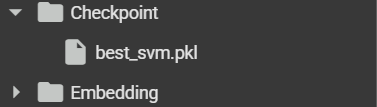

NOTE: For the final version I used local env, as the 2.5M records classification took roughly 10h, and colab wasn't cooperative. You can still use the drive.mount functionality by un-hiding the relevant code piece. Notive that the classification head does not benefit from GPU usage.

In [1]:
import os
import torch
# from google.colab import drive
# drive.mount('/content/drive')

project_root = "C:\\Users\\yonat\\CodeProjects\\Israel-Palestine-Political-Affiliation-Text-Classification"
CHECKPOINTS = os.path.join(project_root, 'Checkpoint')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# classifiers.py

'''
Class to contain the different model, each should be easiliy called for initialization,
fit and predict.
'''
import os
import ast
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pickle
from tqdm import tqdm

# Setting random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # For CUDA (GPU) if you're using it

class DNN(nn.Module):
    def __init__(self, config):
        """
        Initializes a Deep Neural Network (DNN) with the given configuration.

        Args:
            config (dict): Configuration for the DNN.
                {
                    "learning_rate": float,
                    "batch_norm": bool,
                    "drop_out": float,
                    "layers": str(list[int])
                }
        """
        super(DNN, self).__init__()
        layers = []
        if isinstance(config["layers"], str):
            config["layers"] = list(ast.literal_eval(config["layers"]))
        input_size = config["layers"][0]

        # Iterate through the hidden layers
        for output_size in config["layers"][1:-1]:  # Skip the last layer (number of classes)
            layers.append(nn.Linear(input_size, output_size))
            if config.get("batch_norm", False):
                layers.append(nn.BatchNorm1d(output_size))
            layers.append(nn.ReLU())
            if config.get("drop_out", 0.0) > 0:
                layers.append(nn.Dropout(config["drop_out"]))
            input_size = output_size

        # Final classification layer
        num_classes = config["layers"][-1]
        layers.append(nn.Linear(input_size, num_classes))  # Last layer matches num_classes
        # layers.append(nn.Softmax(dim=1))  # Softmax activation for multi-class output

        self.model = nn.Sequential(*layers)
        self.learning_rate = config["learning_rate"]

    def forward(self, x):
        return self.model(x)

class Classifier:
    def __init__(self, config, model_type, log=True, init_model=True):
        """
        Initializes the classifier based on the model type and configuration.

        Args:
            config (dict): Configuration for the model. Format varies based on the model type.
            model_type (str): One of "logistic_regression", "svm", "xgboost", or "dnn".
            log (bool): Print the loss progress? Redundent if epochs are optimized externally.
            init_model (bool): Allows model initialization for loaded model. Called like clf.load() after init.
        """
        self.model_type = model_type
        self.model_params = config          # save for cloning
        self.log = log

        if not init_model:
            self.model = None
            return

        if model_type in ["logistic_regression", "dnn"]:
            # A one layered logistic regression implementation using the DNN class
            self.model = DNN(config)
            self.optimizer = optim.Adam(self.model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
            self.criterion = None  # Will be created in fit() based on label distribution
            self.num_epochs = config["num_epochs"]
        elif model_type == "svm":
            config.setdefault("class_weight", "balanced")  # Balance class weights
            self.model = SVC(random_state=42, **config)
        elif model_type == "xgboost":
            self.model = XGBClassifier(random_state=42, **config)
        else:
            raise ValueError(f"Unsupported model type: {model_type}")


    def fit(self, train_data_package):
        """
        Fits the model to the training data.
        Allows to load an existing model, if training already reached a best saved model.
        Works with the output of the function get_dataloader which gets the desired datashape
        per model.

        Args:
            train_data_package (tuple): A tuple containing (DataLoader, (X, y))
        """
        # ----------------- Determine checkpoint path -----------------
        checkpoint_path = os.path.join(CHECKPOINTS, f'best_{self.model_type}.pt' if self.model_type in ["logistic_regression", "dnn"] else f'best_{self.model_type}.pkl')
        if os.path.exists(checkpoint_path):
            self.log and print(f"[Model Fit Status]: Loading pre-trained {self.model_type} from checkpoint.")

            if self.model_type in ["logistic_regression", "dnn"]:
                self.model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
                self.model.to(DEVICE)
                self.model.eval()
            else:  # sklearn/xgboost
                with open(checkpoint_path, "rb") as f:
                    self.model = pickle.load(f)
            return

        # ----------------- Otherwise, train the model -----------------
        train_dataloader, (X_train, y_train) = train_data_package
        if self.model_type == "svm":
            self.log and print(f'[Model Fit Status]: Fitting the model...')
            self.model.fit(X_train, y_train)
        elif self.model_type == "xgboost":
            self.log and print(f'[Model Fit Status]: Fitting the model...')
            y_train = y_train.detach().cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
            class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train).astype(int), y=y_train.astype(int))
            sample_weight = np.array([class_weights[label] for label in y_train])
            self.model.fit(X_train, y_train, sample_weight=sample_weight)
        elif self.model_type in ["logistic_regression", "dnn"]:
            self.log and print(f'[Model Fit Status]: Fitting the model...')
            y_train = y_train.detach().cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
            class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train).astype(int), y=y_train.astype(int))
            class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
            self.criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
            self.model.train()
            for epoch in range(self.num_epochs):
                for _, (features, labels) in enumerate(train_dataloader):
                    self.optimizer.zero_grad()
                    outputs = self.model(features.float())
                    loss = self.criterion(outputs.squeeze(), labels.long())
                    loss.backward()
                    self.optimizer.step()
                self.log and print(f"Epoch {epoch + 1}: Training Loss = {loss.item()}")


    def _batch_predict_sklearn(self, X, batch_size=1024, proba=False):
        preds, probs = [], []
        for i in tqdm(range(0, len(X), batch_size), desc="Predicting", ncols=100):
            X_batch = X[i:i+batch_size]
            if proba and hasattr(self.model, "predict_proba"):
                batch_probs = self.model.predict_proba(X_batch)
                probs.append(batch_probs)
                preds.append(batch_probs.argmax(axis=1))
            else:
                preds.append(self.model.predict(X_batch))
        predictions = np.concatenate(preds)
        if proba and probs:
            probas = np.concatenate(probs)
            return predictions, probas
        return predictions, None

    def predict(self, test_data_package, proba=False):
        """
        Predicts labels for the given test data. Optionally returns class probabilities.

        Args:
            test_data_package (tuple): (DataLoader, (X, y))
            proba (bool): If True, also return class probabilities.

        Returns:
            list: Predicted labels
            (optional) list: Predicted class probabilities
        """
        predictions = []
        probas = []

        test_dataloader, (X_test, _) = test_data_package

        if self.model_type in ["svm", "xgboost"]:
            self.log and print(f'[Model Pred Status]: Generating predictions...')
            predictions, probas = self._batch_predict_sklearn(X_test, batch_size=1024, proba=proba)
            return (predictions.tolist(), probas.tolist()) if proba else predictions.tolist()

        elif self.model_type in ["logistic_regression", "dnn"]:
            self.log and print(f'[Model Pred Status]: Generating predictions...')
            predictions = []
            probas = []
            self.model.eval()
            with torch.no_grad():
                for _, (features, _) in enumerate(tqdm(test_dataloader, desc="Predicting", ncols=100)):
                    features = features.to(DEVICE)
                    outputs = self.model(features.float())  # shape: (batch_size, num_classes)
                    if proba:
                        probs = torch.softmax(outputs, dim=1)
                        probas.extend(probs.cpu().tolist())
                        preds = torch.argmax(probs, dim=1)
                    else:
                        preds = torch.argmax(outputs, dim=1)
                    predictions.extend(preds.cpu().tolist())
            return (predictions, probas) if proba else predictions

    def save(self, path):
        if self.model_type in ["svm", "xgboost"]:
            with open(path, "wb") as f:
                pickle.dump(self.model, f)
        elif self.model_type in ["logistic_regression", "dnn"]:
            torch.save(self.model.state_dict(), path)

    def load(self, checkpoint_path=None):
        """
        Loads a pre-trained model from disk.
        Args:
            checkpoint_path (str, optional): Path to checkpoint file. If None, uses default from config.
        """
        if checkpoint_path is None:
            checkpoint_path = os.path.join(CHECKPOINTS, f'best_{self.model_type}.pt' if self.model_type in ["logistic_regression", "dnn"] else f'best_{self.model_type}.pkl')

        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"[Load Error] No checkpoint found at: {checkpoint_path}")

        if self.model_type in ["logistic_regression", "dnn"]:
            self.model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
            self.model.to(DEVICE)
            self.model.eval()
        else:
            with open(checkpoint_path, "rb") as f:
                self.model = pickle.load(f)

        self.log and print(f"[Model Load Status]: Loaded pretrained {self.model_type} from {checkpoint_path}")

In [3]:
# embedder_utils from embedder.py

def _to_numpy(t):
    """
    Helper:  tensor  ➜  numpy (always on CPU, detached).
    Accepts torch.Tensor or anything that is already a numpy array.
    """
    if isinstance(t, torch.Tensor):
        return t.detach().cpu().numpy()
    return np.asarray(t)

def get_dataloader(dataset, batch_size=32, shuffle=True, num_workers=2):
    '''
    Will create the DataLoader object.
    Assumption is that a Dataset object is passed. Function will response if the dataset is TextDataset or EmbeddingDataset.
    If EmbeddingDataset, this function will return a Dataloader and a (X, y) tuple for other scikit models.
    Else, if dataset is TextDataset it will return a text dataset for it, which is designed for analysis of Transformer model's feed.
    The function is GPU‑safe:   `.cpu()` before `.numpy()`.

    Args:
        dataset (TextDataset or EmbeddingDataset): The original dataset object.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle the dataset.
        num_workers (int): Number of subprocesses for data loading.

    Returns:
        if type(dataset) == 'TextDataset':
            DataLoader: A PyTorch DataLoader object for text output.
        elif type(dataset) == 'EmbeddingDataset':
            1. DataLoader: A PyTorch DataLoader object for embedding output.
            2. tuple: An (X, y) tuple for other scikit models.
    '''
    print(f'[Dataloader Status]: Preparing the dataloader...')
    pin = torch.cuda.is_available()          # use pinned memory when GPU present
    dl = DataLoader(dataset,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    num_workers=num_workers,
                    pin_memory=pin)

    # --- TextDataset: nothing else to do ---------------------------------
    if 'TextDataset' in dataset.__class__.__name__:
        return dl

    # -------- EmbeddingDataset or its _View -------------------------------------
    if isinstance(dataset, EmbeddingDataset) or isinstance(dataset, EmbeddingDataset._View):
        # quick peek at first batch
        for b, (_, y_b) in enumerate(dl):
            print(f"[DL] peek batch {b}: y[:5] =", _to_numpy(y_b)[:5])
            break

        X = _to_numpy(dataset.embeddings)
        y = _to_numpy(dataset.labels)
        print(f"[DL] EmbeddingDataset ready. X shape {X.shape}, y len {len(y)}")
        return dl, (X, y)

    # -------- unknown dataset ---------------------------------------------------
    raise ValueError(f"[DL] Unrecognized dataset type: {type(dataset)}")

def patch_cached_labels(pkl_path):
    '''
    Had a reccurring problem with the datasets so added this utility to fix the label encodings
    of a cached dataset without having to re-calculate.

    Use like:
    patch_cached_labels("Data/cache/distilbert_embeddings_regular.pkl")
    '''
    with open(pkl_path, 'rb') as f:
        blob = pickle.load(f)

    labels = blob["labels"]
    if not torch.is_tensor(labels):
        labels = torch.tensor(labels, dtype=torch.long)

    # Fix labels that are outside expected range
    corrected_labels = []
    for lbl in labels:
        lbl_int = int(lbl)
        if lbl_int in LABELS_ENCODER.values():
            corrected_labels.append(lbl_int)
        else:
            print(f"[Warning] Skipping invalid label: {lbl_int}")
            corrected_labels.append(-1)  # or raise error if strict

    blob["labels"] = torch.tensor(corrected_labels, dtype=torch.long)

    with open(pkl_path, 'wb') as f:
        pickle.dump(blob, f)

    print(f"[Patch] Labels fixed and saved back to: {pkl_path}")

## Main

In [ ]:
import os
import pandas as pd
import pickle
from tqdm import tqdm

# Constants
FULL_DATA_PATH = "C:\\Users\\yonat\\CodeProjects\\Israel-Palestine-Political-Affiliation-Text-Classification\\Data\\cache\\reddit_opinion_PSE_ISR_cleaned.csv"
EMBEDDING_CACHE = "C:\\Users\\yonat\\CodeProjects\\Israel-Palestine-Political-Affiliation-Text-Classification\\Data\\cache\\distilbert_FULL.pkl"
CHECKPOINT_PATH = "C:\\Users\\yonat\\CodeProjects\\Israel-Palestine-Political-Affiliation-Text-Classification\\Checkpoint\\best_svm.pkl"

LOCAL_SAVE_PATH = "classified_comment_stance.csv"

# Dataset column indices
ID_COLUMN_IDX = 0
COMMENT_COLUMN_IDX = 1
LABEL_COLUMN_IDX = 2  # dummy
SUBSET_COLUMN_IDX = 3

# 1. Load embeddings
print("[Step 1] Loading merged embeddings from disk...")
if not os.path.exists(EMBEDDING_CACHE):
    raise FileNotFoundError(f"Missing merged embedding file: {EMBEDDING_CACHE}")

with open(EMBEDDING_CACHE, "rb") as f:
    ids, X = pickle.load(f)  # tuple: (comment_ids, embeddings)

# 2. Load pretrained SVM
print("[Step 2] Loading pretrained SVM model...")
if not os.path.exists(CHECKPOINT_PATH):
    raise FileNotFoundError(f"SVM checkpoint not found: {CHECKPOINT_PATH}")

svm_clf = Classifier({}, model_type="svm", log=True, init_model=False)
svm_clf.load(CHECKPOINT_PATH)

# 3. Predict
print("[Step 3] Predicting on full dataset (chunked)...")
chunk_size = 1_000
y_pred = []

for i in tqdm(range(0, len(X), chunk_size), desc="Predicting"):
    X_chunk = X[i: i + chunk_size]
    preds = svm_clf.model.predict(X_chunk)
    y_pred.extend(preds)

y_pred = np.array(y_pred)

# 4. Merge predictions into full dataset
print("[Step 4] Merging predictions into full dataset...")
full_df = pd.read_csv(FULL_DATA_PATH)
pred_df = pd.DataFrame({"comment_id": ids, "predicted_label": y_pred})
merged_df = full_df.merge(pred_df, on="comment_id", how="left")

# 5. Save locally and to Drive
print("[Step 5] Saving labeled dataset...")

LABELS_ENCODER = {
    "Pro-Palestine": 0,
    "Pro-Israel": 1,
    "Undefined": 2
}

# Reverse the label encoder
LABELS_DECODER = {v: k for k, v in LABELS_ENCODER.items()}

# Map numeric predicted_label to text
merged_df["predicted_label"] = merged_df["predicted_label"].map(LABELS_DECODER)

# Save to CSV
# Drop rows with NaN in predicted_label
merged_df = merged_df.dropna(subset=["predicted_label"])
merged_df.to_csv(LOCAL_SAVE_PATH, index=False)

print(f"✅ Merged + labeled dataset saved locally to: {LOCAL_SAVE_PATH}")

[Step 1] Loading merged embeddings from disk...
[Step 2] Loading pretrained SVM model...
[Model Load Status]: Loaded pretrained svm from C:\Users\yonat\CodeProjects\Israel-Palestine-Political-Affiliation-Text-Classification\Checkpoint\best_svm.pkl
[Step 3] Predicting on full dataset (chunked)...


Predicting: 100%|██████████| 2684/2684 [13:42:27<00:00, 18.39s/it]  


[Step 4] Merging predictions into full dataset...
[Step 5] Saving labeled dataset...
✅ Merged + labeled dataset saved locally to: classified_comment_stance.csv


In [13]:
# Check if the column exists
if "predicted_label" in merged_df.columns:
    print("✅ 'predicted_label' column exists.")

    # Show basic info about the column
    print("\nValue counts:")
    print(merged_df["predicted_label"].value_counts(dropna=False))

    print("\nColumn type:")
    print(merged_df["predicted_label"].dtype)
else:
    print("❌ 'predicted_label' column is missing from merged_df.")

✅ 'predicted_label' column exists.

Value counts:
predicted_label
Undefined        1835508
Pro-Israel        440587
Pro-Palestine     407135
Name: count, dtype: int64

Column type:
object


In [15]:
display(merged_df[["self_text", "predicted_label"]].head())

,self_text,predicted_label
0,"Again though, his actions are forced by member...",Undefined
1,The German police arresting a Jewish man for a...,Undefined
3,We're already there. The killing just isn't en...,Pro-Palestine
4,Thats not the definition of tokenism. That is ...,Pro-Palestine
5,I dont know if youre being serious but Im goin...,Pro-Palestine
